In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from astropy.table import Table

In [4]:
from sklearn.mixture import GaussianMixture as GMM

In [5]:
import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='deep')

In [6]:
%matplotlib inline

### Read the heapix information table for DR5.
And convert to a pandas dataframe.

In [7]:
def read_infotable():
    infofile = os.path.join(os.getenv('DESI_ROOT'), 'target', 'catalogs', 'hp-info-dr5-0.17.1.fits')
    info = Table.read(infofile)
    cols = ['{}DEPTH_{}_PERCENTILES'.format(prefix, band) for band in ('G', 'R', 'Z') for prefix in ('PSF', 'GAL')]
    info.remove_columns(cols)
    return info.to_pandas()    

In [8]:
_info = read_infotable()
_info

,HPXID,HPXAREA,RA,DEC,EBV,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,...,NEXP_G,NEXP_R,NEXP_Z,DENSITY_ALL,DENSITY_ELG,DENSITY_LRG,DENSITY_QSO,DENSITY_LYA,DENSITY_BGS,DENSITY_MWS
0,0,0.052456,45.000000,0.149208,0.088500,24.575624,24.286928,23.380188,24.343454,23.938946,...,4,2,3,5261.567383,2363.892578,590.973145,362.209351,0.0,2173.256104,0.0
1,1,0.052456,45.175781,0.298417,0.106785,24.486000,24.268520,23.200266,24.241188,23.930630,...,3,2,2,4899.357910,2440.147217,552.845825,457.527588,0.0,1753.855713,0.0
2,2,0.052456,44.824219,0.298417,0.083006,24.630730,24.333153,23.313522,24.393602,23.978317,...,4,2,2,5985.985840,2306.701660,381.272980,171.572845,0.0,3259.884033,0.0
3,3,0.052456,45.000000,0.447628,0.090561,24.559509,24.311333,23.288239,24.317987,23.964497,...,3,2,2,4823.103516,2421.083496,590.973145,247.827438,0.0,1715.728394,0.0
4,4,0.052456,45.351562,0.447628,0.106791,24.343983,24.076357,23.164227,24.101957,23.745398,...,2,1,2,4251.193848,2211.383301,514.718506,209.700150,0.0,1429.773682,0.0
5,5,0.052456,45.527344,0.596842,0.097694,24.225916,23.954306,23.153233,23.985544,23.622919,...,2,1,2,2573.592773,1277.264526,381.272980,133.445541,0.0,934.118835,0.0
6,6,0.052456,45.175781,0.596842,0.095500,24.465931,24.220013,23.273710,24.224958,23.882454,...,3,2,2,4098.684570,2230.447021,438.463928,285.954742,0.0,1315.391846,0.0
7,7,0.052456,45.351562,0.746060,0.093295,24.284094,24.047815,23.294277,24.030888,23.734314,...,2,1,3,4308.384766,2039.810425,629.100403,305.018402,0.0,1563.219238,0.0
8,8,0.052456,44.648438,0.447628,0.081472,24.618589,24.345335,23.159859,24.374355,23.986643,...,3,2,2,5032.803223,2344.828857,228.763794,266.891083,0.0,2363.892578,0.0
9,9,0.052456,44.824219,0.596842,0.083834,24.632193,24.349581,23.189117,24.392372,23.990971,...,4,2,2,5490.331055,2973.929199,457.527588,381.272980,0.0,1925.428589,0.0


#### Select healpixels with three or more exposures in all three (*grz*) bands.
The caps on density are to toss out a handful of couple outliers.

In [9]:
minexp = 3

In [34]:
info = _info.loc[(_info['NEXP_G'] >= minexp) & (_info['NEXP_R'] >= minexp) & 
                 (_info['NEXP_Z'] >= minexp) & 
                 (_info['DENSITY_ELG'] < 5000) & 
                 (_info['DENSITY_LRG'] < 1500) & 
                 (_info['DENSITY_QSO'] < 1000)
                ]
print('There are {} / {} healpixels with >={} exposures in grz.'.format(len(info), len(_info), minexp))

There are 42758 / 152849 healpixels with >=3 exposures in grz.


### Visualize the relationships between density, depth, and reddening for each target class.

In [35]:
def pairplot(target, only_dust=False):
    if only_dust:
        cols = ['DENSITY_{}'.format(target), 'EBV']
    else:
        cols = ['DENSITY_{}'.format(target), 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'EBV']
    sns.pairplot(info, vars=cols, diag_kind='hist', plot_kws={'s': 3}, size=2)

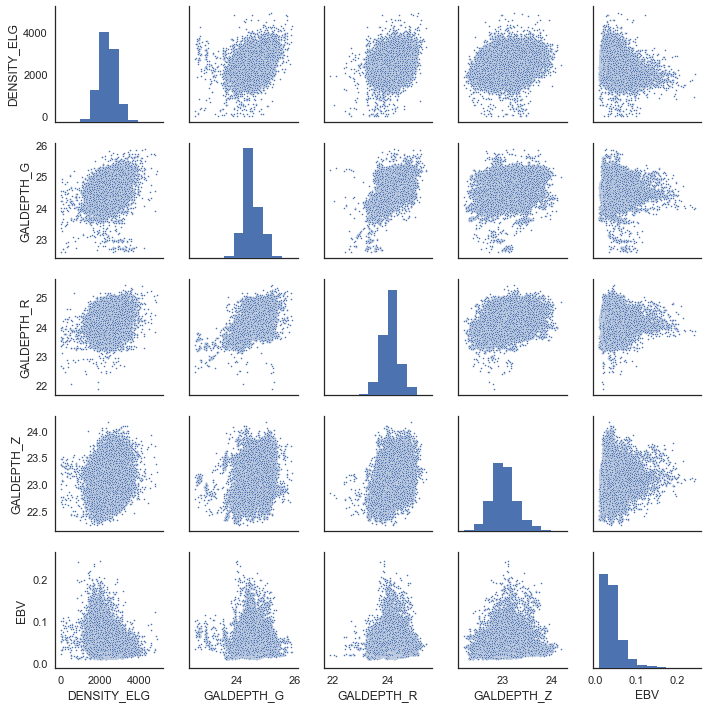

In [38]:
pairplot('ELG')

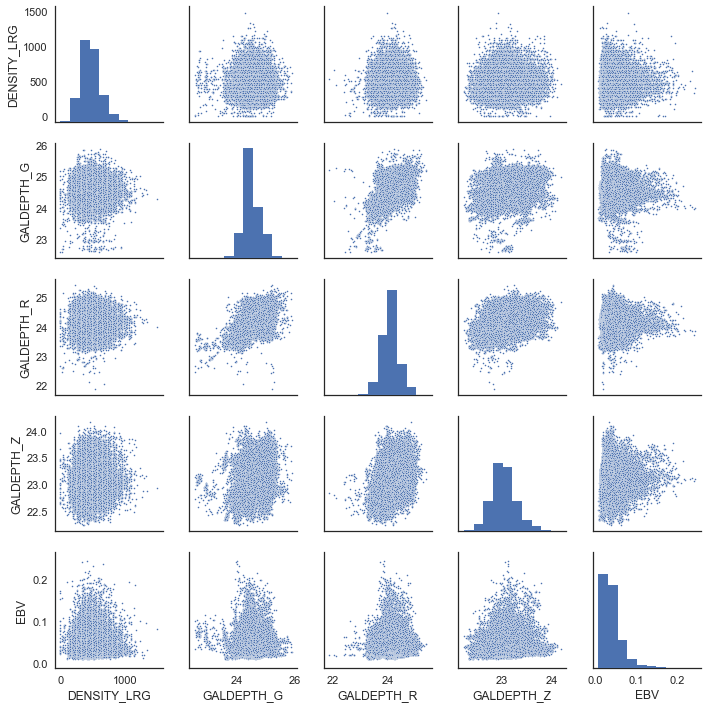

In [37]:
pairplot('LRG')

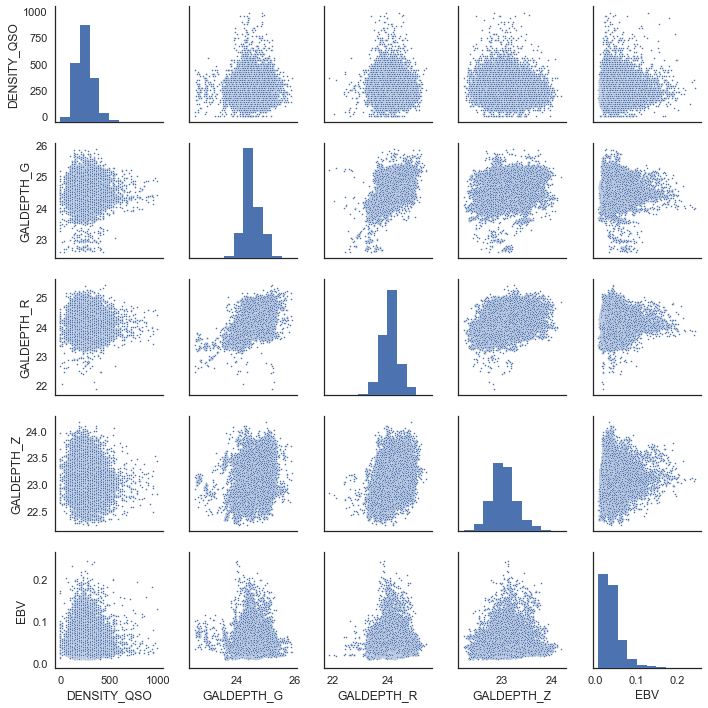

In [36]:
pairplot('QSO')

### Determine the number of Gaussian components needed for each target class (ELG, LRG, QSO).
Regress just against the dust reddening for now.

In [63]:
ncomparray = np.arange(10, 50)

In [64]:
def qa_bic(ncomp, bic, title):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ncomp, bic, marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion')
    ax.set_title(title)

In [65]:
def getbic(target, ncomp=[3]):
    cols = ['DENSITY_{}'.format(target), 'EBV']
    X = info[cols]
    bic = [GMM(n_components=nc).fit(X).bic(X) for nc in ncomp]
    return bic

In [66]:
%time bic_elg = getbic('ELG', ncomparray)

CPU times: user 10min 14s, sys: 18.2 s, total: 10min 32s
Wall time: 2min 39s


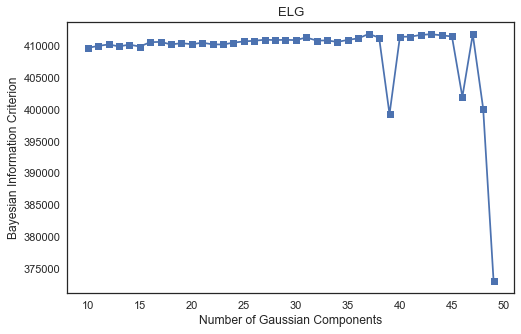

In [67]:
qa_bic(ncomparray, bic_elg, title='ELG')

In [59]:
%time bic_lrg = getbic('LRG', ncomparray)

CPU times: user 3min 5s, sys: 5.84 s, total: 3min 11s
Wall time: 48.3 s


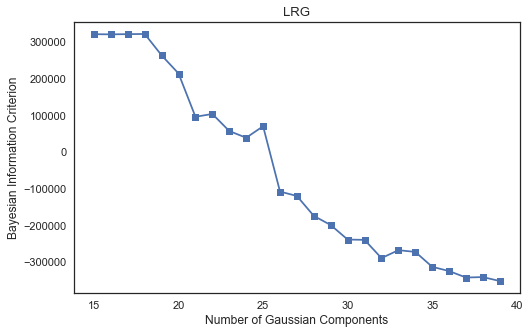

In [60]:
qa_bic(ncomparray, bic_lrg, title='LRG')

In [61]:
%time bic_qso = getbic('QSO', ncomparray)

CPU times: user 1min 26s, sys: 2.56 s, total: 1min 29s
Wall time: 22.5 s


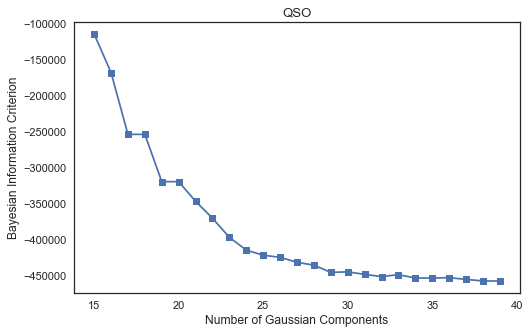

In [62]:
qa_bic(ncomparray, bic_qso, title='QSO')

### Construct a Gaussian mixture model for each target class (ELG, LRG, QSO).


In [17]:
mog = GMM(n_components=10).fit(info[dustcols])

In [12]:
alltarget = ('ELG', 'LRG', 'QSO')

In [18]:
samp = pd.DataFrame(np.vstack(mog.sample(1000)[0]), columns=dustcols)
samp.describe()

,DENSITY_ELG,EBV
count,1000.000000,1000.000000
mean,2395.718341,0.041764
std,435.107867,0.023211
min,701.338385,0.001314
25%,2114.042469,0.026124
50%,2383.327535,0.034490
75%,2683.890851,0.051252
max,4068.797212,0.188177


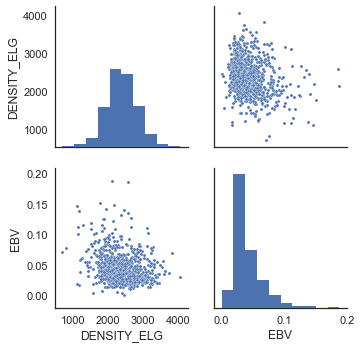

In [19]:
sns.pairplot(samp, plot_kws={'s': 10})